In [1]:
## Data processing imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates

## Data retrieval imports
import psycopg2
import sys

In [2]:
## Make sure you have pytables installed before running this notebook. 
## If you don't have it, just run "python3 -m pip install tables".

In [3]:
## Declare raw log path and processed output path

H5_PATH = 'C:/Users/cheye/OneDrive - purdue.edu/IOT Logisitics/2021/Processed Data/Masters-Research/Iso Blue Data/'
EXCEL_CSV_PATH = 'C:/Users/cheye/OneDrive - purdue.edu/IOT Logisitics/2021/Processed Data/Masters-Research/Iso Blue Data/Wetts Data'

## Declare event, machine, and date from log

EVENT = 'asm345'
MACHINE_ID = 'j320d'
DATE = '09112021'

## Declare experiment start and end time (UTC Time)

START_TIME = '2021-09-11 00:06:57.0+00' #10:06:57
END_TIME = '2021-09-12 00:10:25.0+00'   #10:10:25

H5_NAME = '-'.join([EVENT, MACHINE_ID, DATE, 'wetts09_11.h5'])
EXCEL_CSV_NAME = '-'.join([EVENT, MACHINE_ID, DATE, 'wetts09_11.csv'])

SINGLE = True

In [4]:
## Retrieve data from ISOBlue Database

## Define connection parameters
db_host = "172.16.0.9" ## apalis-12 wireguard IP
#db_host = "192.168.10.1" ## apalis-12 wifi IP
db = "casemgnm330-wettshurack-corn21-apalis-13"

param_dic = {
    "host" : db_host,
    "database" : db,
    "user" : "avena",
    "password" : "password"
}

In [5]:
## Define functions to connect and to retrieve a dataframe from a SQL query.

def connect(params_dic):
    """ Connect to the Postgres database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print(f'Connecting to {params_dic["database"]} postgres database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    
    print("Connection successful")
    return conn

## Get query and store as dataframe

def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
        
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tuples
    tuples = cursor.fetchall()
    cursor.close()
    conn.close()
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tuples, columns=column_names)
    return df

In [6]:
## Connect and get the CAN data for the specified interval
conn = connect(param_dic)

column_names = ["time", "can_interface", "can_id", "can_data"]
#column_names = ["time"]
query = f"""SELECT time, can_interface, can_id, can_data 
           FROM can
           WHERE "time" > '{START_TIME}' AND "time" < '{END_TIME}'
        """

can_log = postgresql_to_dataframe(conn, query, column_names)

Connecting to casemgnm330-wettshurack-corn21-apalis-13 postgres database...
Connection successful


In [7]:
dtypes = {
    'time': str, \
    'can_interface': str, \
    'can_id': str, \
    'can_data': str}

In [8]:
cols = list(dtypes.keys())

In [9]:
datetime_col = [cols[0]]

In [10]:
can_log.head()

,time,can_interface,can_id,can_data
0,2021-09-11 14:23:46.525781+00:00,can0,18FF2403,000000003E0000FF
1,2021-09-11 14:23:46.525208+00:00,can0,18FF1003,FFFF000000000000
2,2021-09-11 14:23:46.524620+00:00,can0,0C000127,C0C05D00FFF0FFFF
3,2021-09-11 14:23:46.524041+00:00,can0,0C000027,C00000FFFFFFFFFF
4,2021-09-11 14:23:46.523454+00:00,can0,18FF2503,00FF00000064FFFF


In [11]:
type(can_log['time'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [12]:
print(len(can_log))

242917


In [13]:
# Discard rows when `ts` is nan
can_log.dropna(subset=['time'], inplace=True)

In [14]:
can_log['time'][1].timestamp()

1631370226.525208

In [15]:
# Convert UTC timestamp to local time zone
can_log['ts_corr'] = can_log['time'].dt.tz_convert('America/New_York').dt.tz_localize(None)

In [16]:
can_log.head()

,time,can_interface,can_id,can_data,ts_corr
0,2021-09-11 14:23:46.525781+00:00,can0,18FF2403,000000003E0000FF,2021-09-11 10:23:46.525781
1,2021-09-11 14:23:46.525208+00:00,can0,18FF1003,FFFF000000000000,2021-09-11 10:23:46.525208
2,2021-09-11 14:23:46.524620+00:00,can0,0C000127,C0C05D00FFF0FFFF,2021-09-11 10:23:46.524620
3,2021-09-11 14:23:46.524041+00:00,can0,0C000027,C00000FFFFFFFFFF,2021-09-11 10:23:46.524041
4,2021-09-11 14:23:46.523454+00:00,can0,18FF2503,00FF00000064FFFF,2021-09-11 10:23:46.523454


In [17]:
# Assign timezone corrected timestamps as indices
can_log = can_log.set_index('ts_corr')
can_log = can_log.drop(columns=['time', 'can_interface'])
idx = can_log.index
idx.rename('ts', inplace=True)
can_log.rename(columns={'can_data' : 'payload'}, inplace=True)

In [18]:
can_log.head()

,can_id,payload
ts,,
2021-09-11 10:23:46.525781,18FF2403,000000003E0000FF
2021-09-11 10:23:46.525208,18FF1003,FFFF000000000000
2021-09-11 10:23:46.524620,0C000127,C0C05D00FFF0FFFF
2021-09-11 10:23:46.524041,0C000027,C00000FFFFFFFFFF
2021-09-11 10:23:46.523454,18FF2503,00FF00000064FFFF


In [19]:
# ISOBUS message masks
MASK_2_BIT = ((1 << 2) - 1)
MASK_3_BIT = ((1 << 3) - 1)
MASK_8_BIT = ((1 << 8) - 1)

def parse_canid(can_id):
    # J1939 header info:
    # http://www.ni.com/example/31215/en/
    # http://tucrrc.utulsa.edu/J1939_files/HeaderStructure.jpg
    if can_id is None:
        return [-1] * 4
    
    header = int(can_id, 16)

    sa = header & MASK_8_BIT
    header >>= 8
    pdu_ps = header & MASK_8_BIT
    header >>= 8
    pdu_pf = header & MASK_8_BIT
    header >>= 8
    res_dp = header & MASK_2_BIT
    header >>= 2
    priority = header & MASK_3_BIT

    pgn = res_dp
    pgn <<= 8
    pgn |= pdu_pf
    pgn <<= 8
    if pdu_pf >= 240:
        # pdu format 2 - broadcast message. PDU PS is an extension of
        # the identifier
        pgn |= pdu_ps
        da = 255
    else:
        da = pdu_ps
        
    return [pgn, sa, da, priority]

In [20]:
can_log[['pgn', 'sa', 'da', 'pri']] = pd.DataFrame([[np.nan, np.nan, np.nan, np.nan]], index=can_log.index)
can_log.head()

,can_id,payload,pgn,sa,da,pri
ts,,,,,,
2021-09-11 10:23:46.525781,18FF2403,000000003E0000FF,NaN,NaN,NaN,NaN
2021-09-11 10:23:46.525208,18FF1003,FFFF000000000000,NaN,NaN,NaN,NaN
2021-09-11 10:23:46.524620,0C000127,C0C05D00FFF0FFFF,NaN,NaN,NaN,NaN
2021-09-11 10:23:46.524041,0C000027,C00000FFFFFFFFFF,NaN,NaN,NaN,NaN
2021-09-11 10:23:46.523454,18FF2503,00FF00000064FFFF,NaN,NaN,NaN,NaN


In [21]:
# Drop dulicated timestamps (TODO: investigate why)
can_log_f = can_log[~can_log.index.duplicated()]

In [22]:
can_log_f.loc[:, ['pgn', 'sa', 'da', 'pri']] = \
    np.reshape(list(can_log_f['can_id'].apply(lambda x: parse_canid(x)).values), (len(can_log_f),4))

C:\Users\cheye\AppData\Local\Temp\ipykernel_23860\1195933580.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  can_log_f.loc[:, ['pgn', 'sa', 'da', 'pri']] = \


In [23]:
can_log_f.head()

,can_id,payload,pgn,sa,da,pri
ts,,,,,,
2021-09-11 10:23:46.525781,18FF2403,000000003E0000FF,65316,3,255,6
2021-09-11 10:23:46.525208,18FF1003,FFFF000000000000,65296,3,255,6
2021-09-11 10:23:46.524620,0C000127,C0C05D00FFF0FFFF,0,39,1,3
2021-09-11 10:23:46.524041,0C000027,C00000FFFFFFFFFF,0,39,0,3
2021-09-11 10:23:46.523454,18FF2503,00FF00000064FFFF,65317,3,255,6


In [24]:
can_log_p = can_log_f.drop(columns=['can_id'])

In [25]:
if SINGLE:
    pass
else:
    doi = ['2019-07-12', \
          '2019-07-13', \
          '2019-07-14', \
          '2019-07-15', \
          '2019-07-16', \
          '2019-07-17', \
          '2019-07-18', \
          '2019-07-19', \
          '2019-07-20', \
          '2019-07-21', \
          '2019-07-22', \
          '2019-07-23', \
          '2019-07-24', \
          '2019-07-25']

    t_start = '01:00:00'
    t_end = '23:59:59'

In [26]:
if SINGLE:
    can_log_p.to_hdf(H5_PATH + H5_NAME, key='df', mode='w')
else:
    pass #TODO: fix to_hdf path
    for d in tqdm(doi):
        c = can_log_p.loc[(d + ' ' + t_start):(d + ' ' + t_end), :]
        if c.empty:
            continue
        c.to_hdf('../data/jkwh-290-' + d + '.h5', key='df', mode='w')

In [27]:
### FINISH RAW CSV TO H5 CONVERSION ###

In [28]:
### BEGIN H5 TO EXCEL CSV FILE CONVERSION ###

In [29]:
h5_log = pd.read_hdf(H5_PATH + H5_NAME)

In [30]:
h5_log.head()

,payload,pgn,sa,da,pri
ts,,,,,
2021-09-11 10:23:46.525781,000000003E0000FF,65316,3,255,6
2021-09-11 10:23:46.525208,FFFF000000000000,65296,3,255,6
2021-09-11 10:23:46.524620,C0C05D00FFF0FFFF,0,39,1,3
2021-09-11 10:23:46.524041,C00000FFFFFFFFFF,0,39,0,3
2021-09-11 10:23:46.523454,00FF00000064FFFF,65317,3,255,6


In [31]:
h5_log['ts'] = h5_log.index

In [33]:
h5_log.head()

,payload,pgn,sa,da,pri,ts
ts,,,,,,
2021-09-11 10:23:46.525781,000000003E0000FF,65316,3,255,6,2021-09-11 10:23:46.525781
2021-09-11 10:23:46.525208,FFFF000000000000,65296,3,255,6,2021-09-11 10:23:46.525208
2021-09-11 10:23:46.524620,C0C05D00FFF0FFFF,0,39,1,3,2021-09-11 10:23:46.524620
2021-09-11 10:23:46.524041,C00000FFFFFFFFFF,0,39,0,3,2021-09-11 10:23:46.524041
2021-09-11 10:23:46.523454,00FF00000064FFFF,65317,3,255,6,2021-09-11 10:23:46.523454


In [34]:
h5_log['ts'] = h5_log['ts'].apply(lambda x: x.timestamp())

In [35]:
h5_log.to_csv(EXCEL_CSV_PATH + EXCEL_CSV_NAME, index=False)

In [36]:
## END H5 TO EXCEL CSV CONVERSION ##

In [37]:
## BEGIN DATA VALIDATION ##

In [38]:
can_log = pd.read_hdf(H5_PATH + H5_NAME)

In [66]:
pgns = {
    61444: {'bytes': list(range(32,40)) + list(range(24,32)), 'offset': 0, 'resolution': 0.125, 'name': 'Engine RPM', 'unit': 'RPM'},
    65534: {'bytes': list(range(16,24)), 'offset': 0, 'resolution': 0.01, 'name': 'AugerIO','unit': 'mm'},
    65267: {'bytes': list(range(0,8)) + list(range(8,16)) + list(range(16,24)) + list(range(32,40)), 'offset': 0, 'resolution': 0.0000001, 'name': 'Longitude', 'unit': 'degrees'},
    65267: {'bytes': list(range(56,64)) + list(range(48,56)) + list(range(40,48)) + list(range(32,40)), 'offset': 0, 'resolution': 0.0000001, 'name': 'Latitude', 'unit': 'degrees'},
    65266: {'bytes': list(range(0,8)), 'offset': 0, 'resolution': 0.01, 'name': 'Heading', 'unit': 'degrees'},
    65256: {'bytes': list(range(32,40)) + list(range(16,32)), 'offset': 0, 'resolution': 0.00390625, 'name': 'Speed', 'unit': 'm/s'}
}


In [67]:
def hex2bin(hex_str):
    scale = 16 # equals to hexadecimal
    num_of_bits = 64
    return str(bin(int(hex_str, scale))[2:].zfill(num_of_bits))

def map2col(n, payload_bin_str):
    bin_vals = list(payload_bin_str)
    return bin_vals[n]

Working on PGN 61444
Mapping ...
Done
Working on PGN 65266
Mapping ...
Done
Working on PGN 65128
Mapping ...
Done
Working on PGN 65534
Mapping ...
Done
Working on PGN 65267
Mapping ...
Done
Working on PGN 65256
Mapping ...
Done


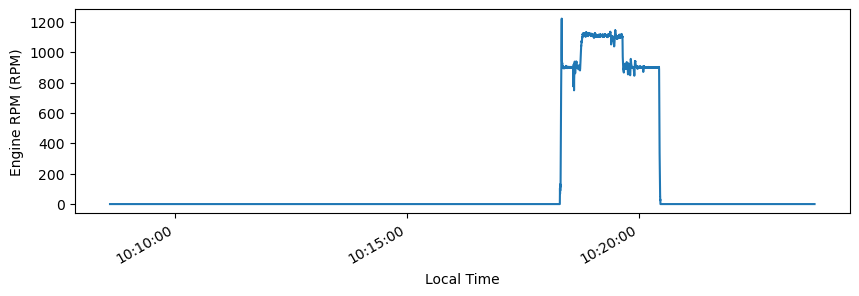

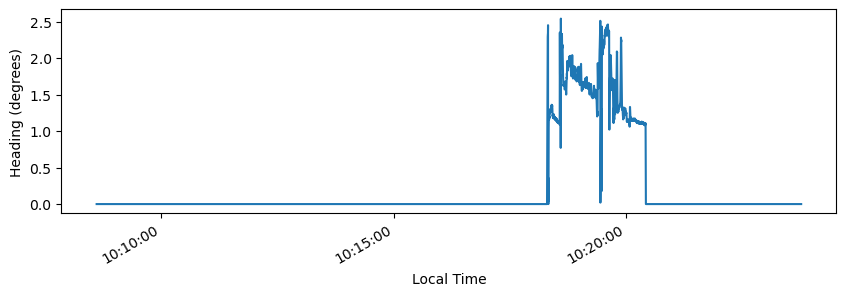

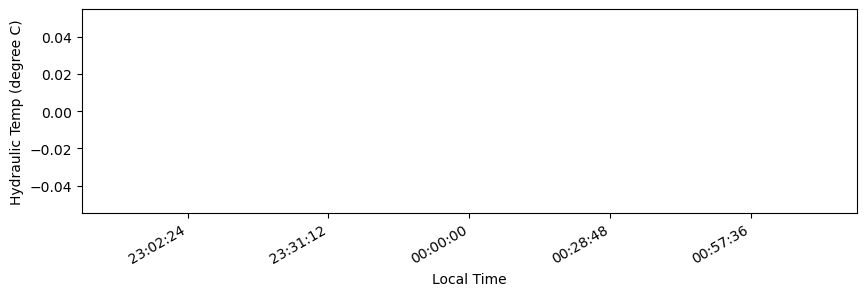

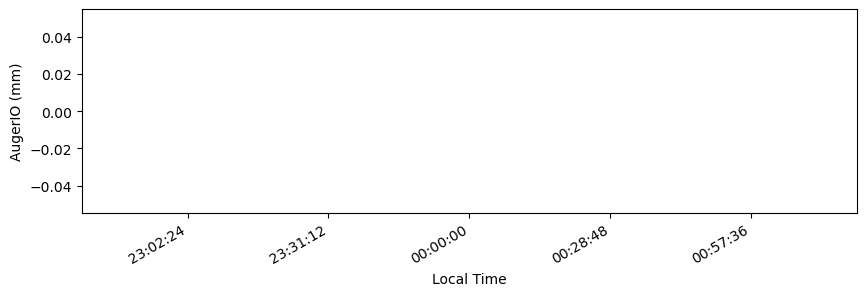

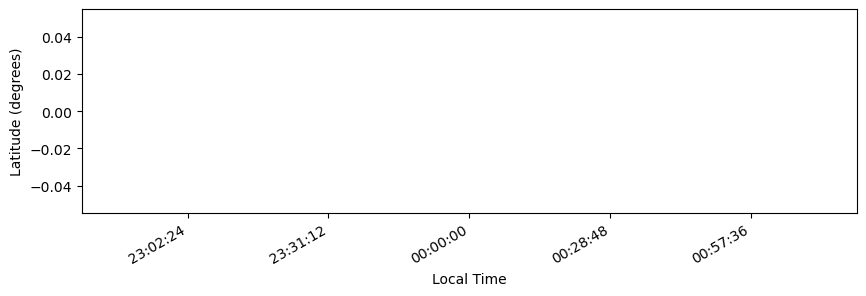

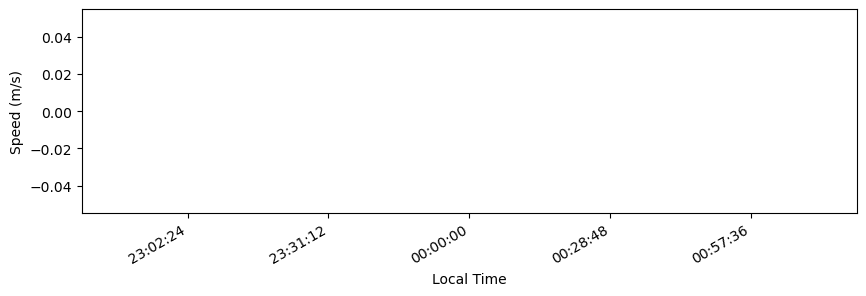

In [68]:
for pgn, d in pgns.items():
    print('Working on PGN {}'.format(pgn))
    log_f = can_log[can_log['pgn'] == pgn]
    bins = log_f['payload'].apply(lambda x: hex2bin(x))
    bins_col = pd.DataFrame()
    print('Mapping ...')
    for n in range(64):
        bins_col[n] = bins.apply(lambda x: map2col(n, x))
    print('Done')
    bins_col = bins_col.astype(int)
    s_dec = bins_col[d['bytes']].astype(str).apply(lambda x: int((''.join(x)), 2) * d['resolution'] + d['offset'], axis=1)
#     s_dec_s = s_dec.resample('1s').mean()
    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(s_dec.index, s_dec.values)
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M:%S"))
    ax.set_xlabel('Local Time')
    ax.set_ylabel('{} ({})'.format(d['name'], d['unit']))
    #ax.set_xlim(left=pd.Timestamp("2021-11-11 15:50:00"), right=pd.Timestamp("2021-11-11 15:56:00"))

In [ ]:
## Connect and get the CAN data for the specified interval
conn = connect(param_dic)

column_names = ["time", "can_interface", "can_id", "can_data"]
#column_names = ["time"]
query = f"""SELECT time, can_interface, can_id, can_data 
           FROM gps
           WHERE "time" > '{START_TIME}' AND "time" < '{END_TIME}'
        """

can_log = postgresql_to_dataframe(conn, query, column_names)